In [1]:
import numpy as np
import os
import pandas as pd
import h5py
from scipy.io import loadmat
import socket
import matplotlib.pyplot as plt
import seaborn as sns

hostname = socket.gethostname()
p = {}
if hostname == 'syndrome' or hostname == 'zod.psych.nyu.edu' or hostname == 'zod':
    p['datd'] = '/d/DATD/datd/MD_TMS_EEG'
else:
    p['datd'] = '/Users/mrugankdake/Documents/Clayspace/EEG_TMS/datd/MD_TMS_EEG'
p['data'] = p['datd'] + '/data'
p['analysis'] = p['datd'] + '/analysis'
p['EEGfiles'] = p['datd'] + '/EEGfiles'
p['meta'] = p['analysis'] + '/meta_analysis'
p['df_fname'] = os.path.join(p['meta'], 'calib_filtered.csv')
p['ALI_evoked'] = os.path.join(p['EEGfiles'], 'ALI_evoked.mat')
p['ALI_induced'] = os.path.join(p['EEGfiles'], 'ALI_induced.mat')
p['training_data'] = os.path.join(p['EEGfiles'], 'training_data.npy')
# Load up summary meta-data
summary_df = pd.read_csv(os.path.join(p['analysis'] + '/EEG_TMS_meta_Summary.csv'))
All_metadata = {row['Subject ID']: row for _, row in summary_df.iterrows()}

# Load up behavioral data
df_behav = pd.read_csv(p['df_fname'])
df_behav['trl_idx'] = df_behav['rnum'] * df_behav['tnum']

In [16]:
with h5py.File(p['ALI_evoked'], 'r') as f:
    X_evoked = np.array(f['mALI']).T
    y_evoked = np.array(f['trl_mat']).T
yevoked_df = pd.DataFrame(y_evoked, columns = ['subjID', 'day', 'istms', 't_type', 'trl_idx'], dtype='int')

with h5py.File(p['ALI_induced'], 'r') as f:
    X_induced = np.array(f['mALI']).T
    y_induced = np.array(f['trl_mat']).T
yinduced_df = pd.DataFrame(y_induced, columns = ['subjID', 'day', 'istms', 't_type', 'trl_idx'], dtype='int')

with h5py.File(os.path.join(p['EEGfiles'], 'sub01/day01/sub01_day01_TFR_evoked.mat')) as f:
    time_array = np.array(f['POW']['pin']['time'])

yevoked_df = yevoked_df.drop(columns=['istms'])
master_df = pd.merge(df_behav.reset_index(), yevoked_df.reset_index(), on=['subjID', 'day', 'trl_idx'], how='inner', indicator=True)
idx_behav = master_df['index_x'].tolist()
idx_ALI = master_df['index_y'].tolist()
master_df = master_df.drop(columns=['index_x', 'Unnamed: 0', 'index_y', '_merge'])
X_evoked = X_evoked[idx_ALI, :]
X_induced = X_induced[idx_ALI, :]

trial_types = ['pin', 'pout', 'ain', 'aout']

/var/folders/0w/p5w49zc93976_p2hxj1zws2w0000gn/T/ipykernel_75464/2359671156.py:5: RuntimeWarning: Mean of empty slice
  ax.plot(time_array, np.nanmean(X_evoked[idx, :], 0), 'k-', label='evoked')
/var/folders/0w/p5w49zc93976_p2hxj1zws2w0000gn/T/ipykernel_75464/2359671156.py:6: RuntimeWarning: Mean of empty slice
  ax.plot(time_array, np.nanmean(X_induced[idx, :], 0), 'b-', label='induced')


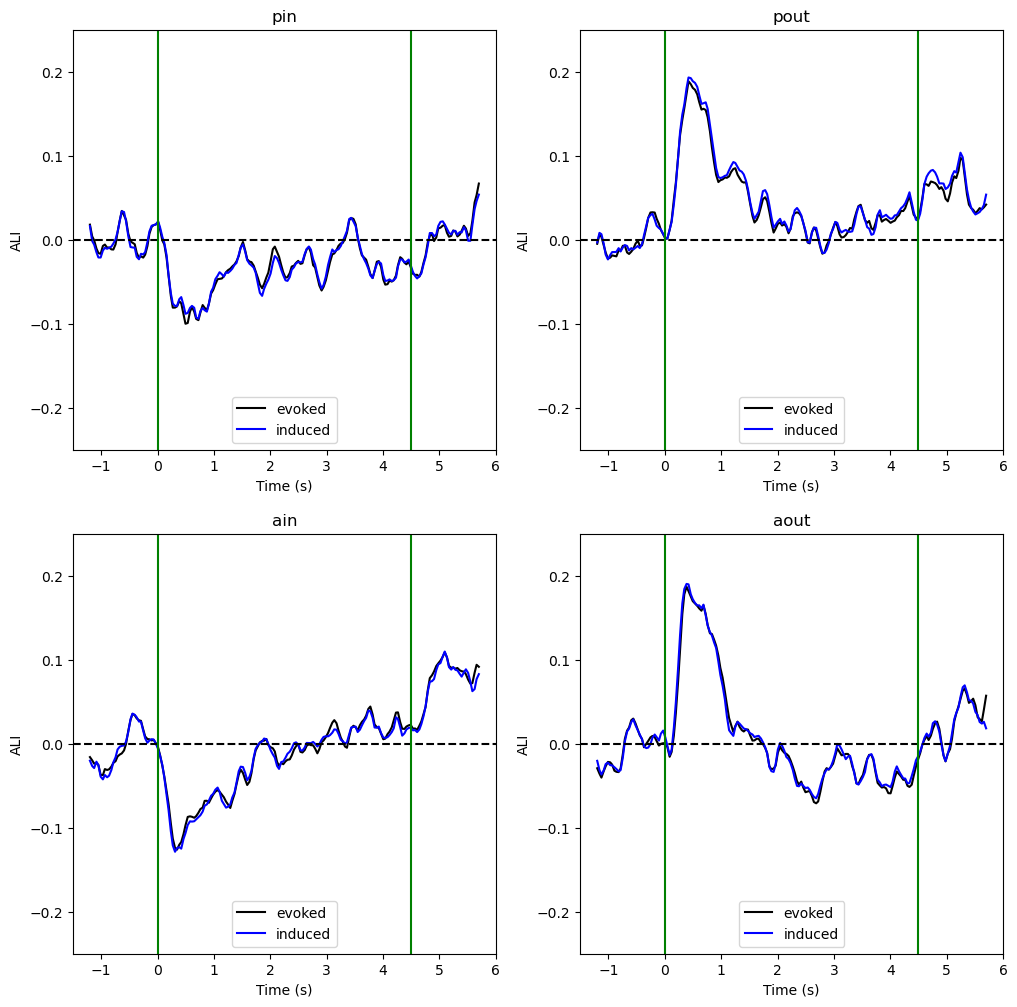

In [18]:
## ALIs for evoked vs induced for No TMS
f, axs = plt.subplots(2, 2, figsize=(12, 12))
for t_type, ax in zip([1,2,3,4], axs.ravel()):
    idx = master_df.loc[(master_df['istms'] == 0) & (master_df['t_type'] == t_type)].index
    ax.plot(time_array, np.nanmean(X_evoked[idx, :], 0), 'k-', label='evoked')
    ax.plot(time_array, np.nanmean(X_induced[idx, :], 0), 'b-', label='induced')
    ax.plot(time_array, np.zeros(len(time_array)), 'k--')
    ax.plot([0, 0], [-0.25, 0.25], 'g-')
    ax.plot([4.5, 4.5], [-0.25, 0.25], 'g-')
    ax.legend()
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(-0.25, 0.25)
    ax.set_ylabel('ALI')
    ax.set_xlabel('Time (s)')
    ax.set_title(trial_types[t_type-1])

/var/folders/0w/p5w49zc93976_p2hxj1zws2w0000gn/T/ipykernel_75464/4000976937.py:6: RuntimeWarning: Mean of empty slice
  ax.plot(time_array, np.nanmean(X_evoked[idx_nt, :], 0), 'b-', label='no tms')
/var/folders/0w/p5w49zc93976_p2hxj1zws2w0000gn/T/ipykernel_75464/4000976937.py:7: RuntimeWarning: Mean of empty slice
  ax.plot(time_array, np.nanmean(X_evoked[idx_t, :], 0), 'r-', label='tms')


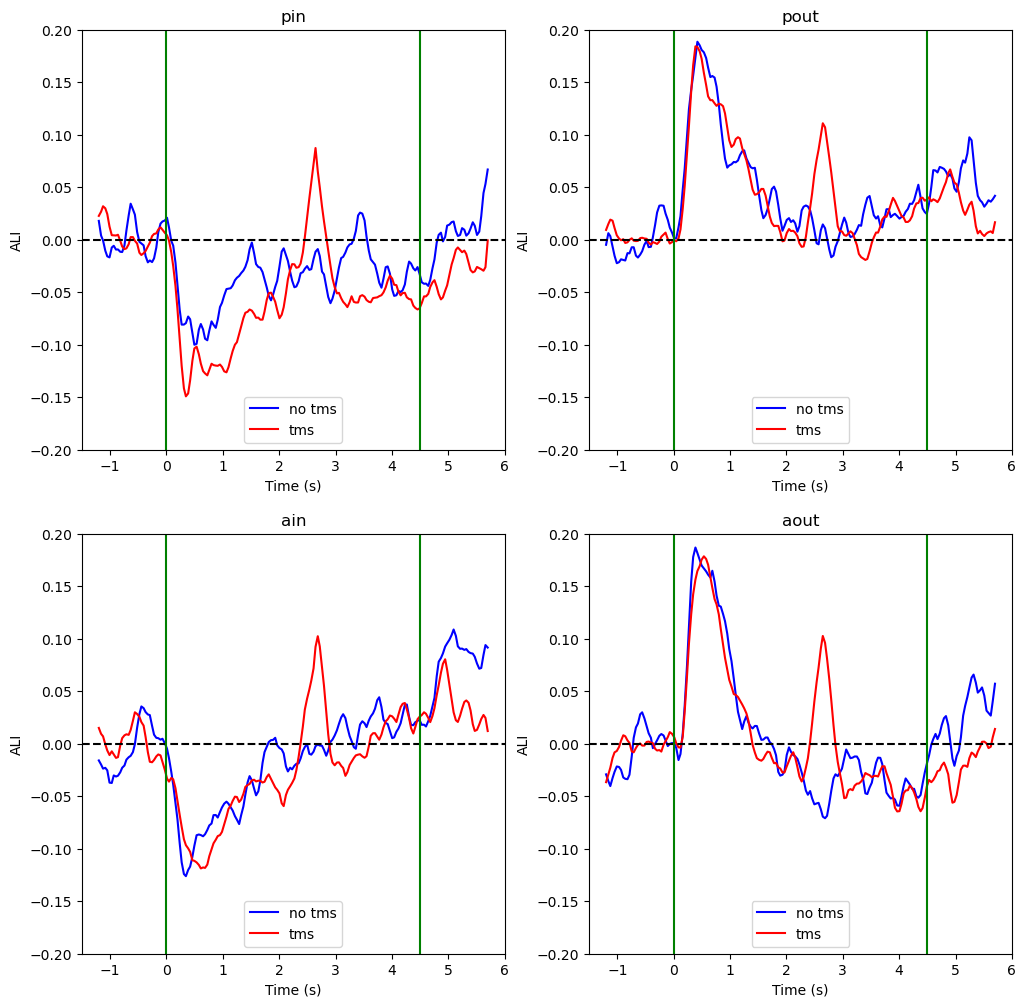

In [19]:
## ALIs for induced for No TMS vs TMS
f, axs = plt.subplots(2, 2, figsize=(12, 12))
for t_type, ax in zip([1,2,3,4], axs.ravel()):
    idx_nt = master_df.loc[(master_df['istms'] == 0) & (master_df['t_type'] == t_type)].index
    idx_t = master_df.loc[(master_df['istms'] == 1) & (master_df['t_type'] == t_type)].index
    ax.plot(time_array, np.nanmean(X_evoked[idx_nt, :], 0), 'b-', label='no tms')
    ax.plot(time_array, np.nanmean(X_evoked[idx_t, :], 0), 'r-', label='tms')
    ax.plot(time_array, np.zeros(len(time_array)), 'k--')
    ax.plot([0, 0], [-0.2, 0.2], 'g-')
    ax.plot([4.5, 4.5], [-0.2, 0.2], 'g-')
    ax.legend()
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(-0.2, 0.2)
    ax.set_ylabel('ALI')
    ax.set_xlabel('Time (s)')
    ax.set_title(trial_types[t_type-1])

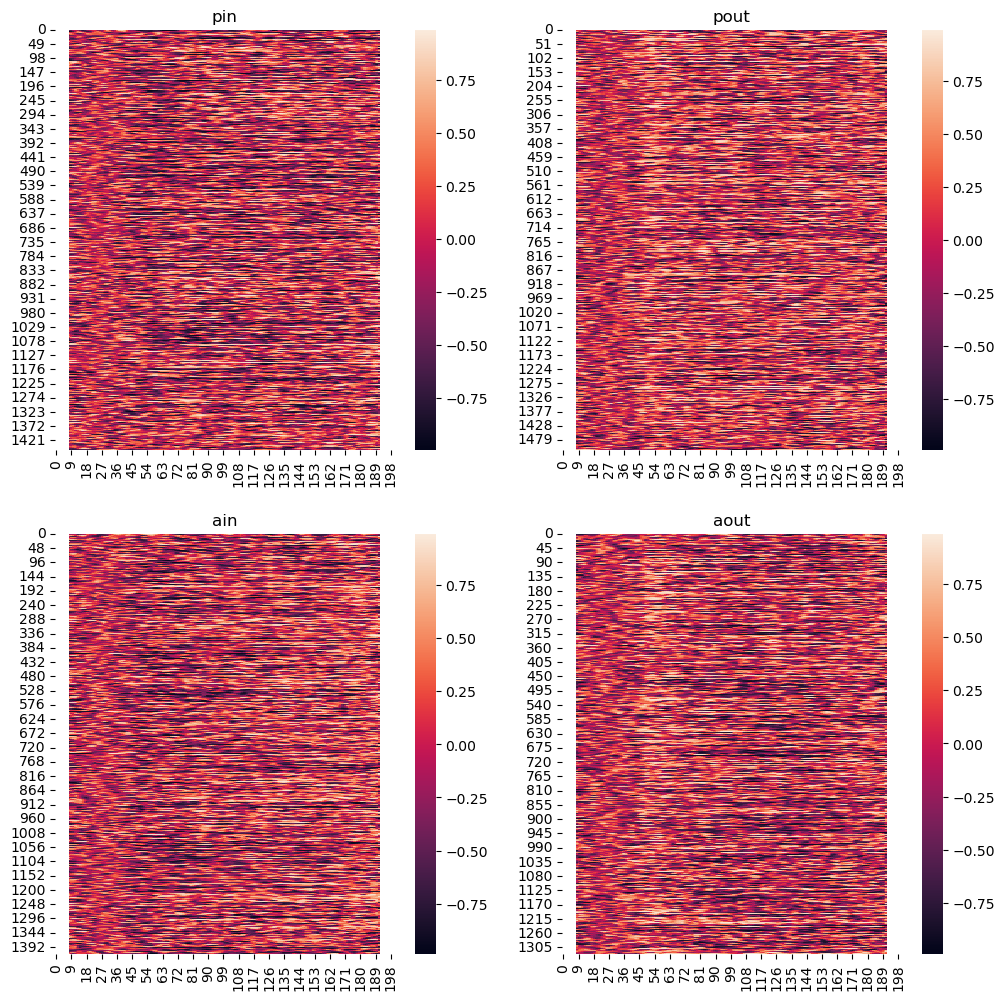

In [22]:
## ALIs for evoked vs induced for No TMS
f, axs = plt.subplots(2, 2, figsize=(12, 12))
for t_type, ax in zip([1,2,3,4], axs.ravel()):
    idx = master_df.loc[(master_df['istms'] == 0) & (master_df['t_type'] == t_type)].index
    tdf = master_df.loc[idx]
    #X_temp = X_evoked[idx, :]
    sorted_df = tdf.sort_values(by='ierr', ascending=False)
    sorted_indices = sorted_df.index.tolist()
    sns.heatmap(X_evoked[sorted_indices, :], ax=ax)
    ax.set_title(trial_types[t_type-1])